##**YOLOv3 Implementation on Google Colab.**

This is an implementation of YOLOv3 for the por man like me that doesn't have a CPU.

##Utilitaries examples:

### Download a file from github
!wget https://raw.githubusercontent.com/pjreddie/darknet/master/examples/detector.c

###  Rename a file, in this case is stored in the folder content/darknet/weights
!mv weights/_darknet-tiny_900.weights weights/yolo3-tiny.conv.22.900

### Find a group of files inone folder and move to other folder
!find ./backup -name '*.weights' -exec mv --target-directory='./weights/' '{}' +

### Change the permissions of the file
!chmod +x _darknet-tiny_train.txt

### Print the active directory
!pwd

### List all files
!ls -la *.txt

### Unmount the google drive
!fusermount -u /gdrive

### Check a string inside of a file
!grep "OPENCV=" Makefile

### View the tabs, indent and end of line characters of a file
!cat -e -t -v detector.c

### Playing with dictionaries
- print([x for x in thisdict])
- print(len(thisdict))
- for x, y in thisdict.items():
-   print(x, y)

### Search for a process
!ps -fC darknet

### Kills a process
!pkill darknet

**Step 0:  **These are utility routines that i will use in all the example.  You do not need to worry about modifying files, the script will did it for you.

In [0]:
#
# Mount the drive
#
 def gdrive_mount(path):
    from google.colab import drive
    
    drive.mount(path)
    
#
# Unmount the drive
#
 def gdrive_umount(path):
   !fusermount -u path

#
# Import a file or files to a destination folder
#
def import_file_to_folder(folder):
  import os
  from google.colab import files  
  
  
  if os.path.exists(folder):
    os.chdir(folder)
  else:
    print('[INFO] - The given path does not exists in the file system')
    return
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('[INFO] - User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

    
#    
# Original File from the LearnOpenCV github
# https://raw.githubusercontent.com/spmallick/learnopencv/master/YOLOv3-Training-Snowman-Detector/splitTrainAndTest.py
#
def split_data_set(image_dir, test_set_percentage):
  import random
  import os
  import subprocess
  import sys

  
  f_val = open("_yolov3-tiny_test.txt", 'w')
  f_train = open("_yolov3-tiny_train.txt", 'w')

  path, dirs, files = next(os.walk(image_dir))
  data_size = len(files)

  ind = 0
  data_test_size = int(test_set_percentage * data_size)
  test_array = random.sample(range(data_size), k=data_test_size)

  for f in os.listdir(image_dir):
    if(f.split(".")[1] == "jpg"):
      ind += 1
      if ind in test_array:
        f_val.write("./" + image_dir + f + '\n')
      else:
        f_train.write("./" + image_dir + f + '\n')
  print("[INFO] - Generated " + str(data_test_size) + " images on the test set.")
  print("[INFO] - Generated " + str(data_size) + " images on the training set.")

#        
# Original File from the LearnOpenCV github
# https://raw.githubusercontent.com/spmallick/learnopencv/master/YOLOv3-Training-Snowman-Detector/getDataFromOpenImages_snowman.py
# classes will be in the format ["person", "cat", "dog"]
#

def download_openimages(classes, start=0, numberOfAnnotations=0):
    import csv
    import subprocess
    import os

    
    runMode = "train"
    classes = classes

    with open('class-descriptions-boxable.csv', mode='r') as infile:
      reader = csv.reader(infile)
      dict_list = {rows[1]:rows[0] for rows in reader}
    print("[INFO] - Removing (if exists) and Creating directory 'img' in %s" % (os.getcwd()))
    subprocess.run(['rm', '-rf', 'img'])
    subprocess.run([ 'mkdir', 'img'])
    print("[INFO] - Removing (if exists) and Creating directory 'lbl' in %s" % (os.getcwd()))
    subprocess.run(['rm', '-rf', 'lbl'])
    subprocess.run([ 'mkdir', 'lbl'])

    totalClasses = len(classes)
    for ind in range(0, totalClasses):
      if numberOfAnnotations == 0:
        print("[INFO] - Nothing to download.  Please change the number of annotations to download.")
        break
        
      className = classes[ind]
      print("[INFO] - Class " + str(ind + 1) + "/" + str(totalClasses) + " : " + className)

      commandStr = "grep " + dict_list[className] + " " + runMode + "-annotations-bbox.csv"

      class_annotations = subprocess.run(commandStr.split(), stdout=subprocess.PIPE).stdout.decode('utf-8')
      class_annotations = class_annotations.splitlines()

      totalNumOfAnnotations = len(class_annotations)
      if numberOfAnnotations < 0:
        cnt = 0
        start = 0
        numberOfAnnotations = totalNumOfAnnotations
      else:
        cnt = start
        totalNumOfAnnotations = start + numberOfAnnotations
      i = 1
      print("[INFO] - Total number of annotations to download: " + str(numberOfAnnotations))   
      print("[INFO] - Starting from annotation %i." % (start))
      for line in class_annotations[start:totalNumOfAnnotations]:
        print("[INFO] - Annotation count : " + str(cnt) + ". " + str(i) + " of " + str(numberOfAnnotations) + " = %.4f%%" % (100*i/numberOfAnnotations))
        lineParts = line.split(',')
        subprocess.run([ 'aws', 's3', '--no-sign-request', '--only-show-errors', 'cp', 's3://open-images-dataset/'+runMode+'/'+lineParts[0]+".jpg", 'img/'+lineParts[0]+".jpg"])
        with open('lbl/%s.txt'%(lineParts[0]),'a') as f:
            f.write(' '.join([str(ind),str((float(lineParts[5]) + float(lineParts[4]))/2), str((float(lineParts[7]) + float(lineParts[6]))/2), str(float(lineParts[5])-float(lineParts[4])),str(float(lineParts[7])-float(lineParts[6]))])+'\n')
        cnt = cnt + 1
        i   = i + 1

#
# get platform information
#
def get_platform_info():
  import platform
  
  # print platform info
  print(platform.platform())
  # print nvidia drivers information, for fun
  !cat /proc/driver/nvidia/version
  !nvcc -V
  !nvidia-smi

#
#  Uses matplotlib to display an image in colab
#
def plot_image(img_file_path):
  import matplotlib.pyplot as plt
  import matplotlib.image as mpimg
  import numpy as np
  import os


  if os.path.exists(img_file_path):
    img     = mpimg.imread(img_file_path)
    imgplot = plt.imshow(img, aspect='auto')
    imgplot.axes.get_xaxis().set_visible(False)
    imgplot.axes.get_yaxis().set_visible(False)

  else:
    print('[INFO] - Please verify the specified path or file extension')


#
# Download a file to a directory
#
def fdownload(dest_path, url):
  import os
  import urllib.request
  
  
  fname = url.split('/')[-1]
  os.chdir(dest_path)
  if not os.path.exists(fname):
    print('[INFO] - Downloading ' + fname + ' from: ' + url)
    response = urllib.request.urlopen(url)
    info = response.read()
    info = info.decode("utf-8")
    with open(fname, 'w') as f:
      f.write(info)
      f.close()
    print('[INFO] - ' + fname + ' download completed successfully to ' + dest_path)
  else:
    print('[INFO] - The file ' + fname + ' already exists in ' + dest_path + '.')
    

#
# Modify the lines of a file
#
def fmodifylines(dest_path, fname, linedict):
  with open(fname, 'r+') as f:
    lines = f.readlines()
    for line, value in linedict.items():
      svalue = str(value.split('\n')[0])
      print('[INFO] - Replacing line ' + str(line) + ' in ' + fname + ' as ' + svalue)
      lines[line] = value
    text = ''.join(lines)
    f.close()
  with open(fname, 'w') as f:
    f.write(text)
    f.close()
  print('[INFO] - File modification of ' + fname + ' completed and stored in ' + dest_path)
    
    
#
# Automatically change flags
#
def modify_makefile(EnGPU = 1, EnCUDNN = 0, EnOpenCV = 0, darknetdir='/content/darknet/'):
  import os
  import urllib.request
  
  
  MakefileDict = {
      0:"GPU=" + str(EnGPU) + '\n',
      1:'CUDNN=' + str(EnCUDNN) + '\n',
      2:'OPENCV=' + str(EnOpenCV) + '\n',
      6:'ARCH= -gencode arch=compute_37,code=sm_37 \\' + '\n'
  }
  url = 'https://raw.githubusercontent.com/pjreddie/darknet/master/Makefile'
  fdownload(darknetdir, url)
  fname = url.split('/')[-1]
  fmodifylines(darknetdir, fname, MakefileDict)  
  
  
#
# Automatically change line of file detector.c
#
def modify_detector_c(coarse=1000, fine=200, detectordir='/content/darknet/examples/'):
  import os
  import urllib.request
  
  
  DetectorDict = {
      137:'        if(i%' + str(coarse) + '==0 || (i < ' + str(fine*10) + ' && i%' + str(fine)+ ' == 0)){' + '\n'
  }
  url = 'https://raw.githubusercontent.com/pjreddie/darknet/master/examples/detector.c'    
  detectordir = darknetdir + detectordir
  fdownload(detectordir, url)
  fname = url.split('/')[-1]
  fmodifylines(detectordir, fname, DetectorDict)  
  

#
# Creates a directory
#
def create_dir(fdir):
  if not os.path.exists(fdir):
    os.mkdir(fdir)
    print("[INFO] - Created " + fdir)
  else:
    print("[INFO] - Directory " + fdir + " already exists.")
    
#
# Creates the data configuration file _yolov3-tiny.data
#
def create_data_file(dirs=["cfg", "data", "backup"], nclasses=1, fname="_yolov3-tiny"):
  fdata    = "./" + dirs[0]  + fname + ".data"
  ftrain   = "./" + fname    + "_train.txt"
  fvalid   = "./" + fname    + "_test.txt"
  fnames   = "./" + dirs[1]  + fname + ".names"
  pathbck  = "./" + dirs[2]
  f_tiny_data = open("./" + fdata, 'w')
  f_tiny_data.write("classes =" + str(nclasses) + '\n')
  f_tiny_data.write("train = %s\n" % (ftrain))
  f_tiny_data.write("valid = %s\n" % (fvalid))
  f_tiny_data.write("names = %s\n" % (fnames))
  f_tiny_data.write("backup = %s\n" % (pathbck))
  f_tiny_data.close()
  print("[INFO] - Created " + fdata + " successfully.")  
  print("[INFO] - classes = %s" %(nclasses))
  print("[INFO] - train  path = %s" %(ftrain))
  print("[INFO] - valid  path = %s" %(fvalid))
  print("[INFO] - names  path = %s" %(fnames))
  print("[INFO] - backup path = %s" %(pathbck))
  print("[INFO] - Please verify those are the correct paths, we use /content/darket/ as current directory")

  
#
# Creates the configuration file _yolov3-tiny.cfg
#  
def create_cfg_file(cfgdir='cfg/', hyperp=0, nclasses=1, max_batches=2000, fname="_yolov3-tiny"):
  import os
  import urllib.request
  from shutil import copyfile as cp

  fcfg  = fname + ".cfg"
  cp("./" + cfgdir + "yolov3-tiny.cfg", cfgdir + fcfg)
  max_batches_min = 2000*nclasses
  if max_batches < max_batches_min:
    max_batches = max_batches_min
  batches = hyperp[0][0]
  subdivisions = hyperp[0][1]
  width = hyperp[1][0]
  height = hyperp[1][1]
  channels = hyperp[1][2]
  momentum = hyperp[2][0]
  decay = hyperp[2][1]
  learning_rate=hyperp[3][0]
  steps=hyperp[3][1]
  scales=hyperp[3][2]
  burn_in=hyperp[3][3]
  angle = hyperp[4][0]
  saturation = hyperp[4][1]
  exposure = hyperp[4][2]
  hue = hyperp[4][3]
  filters=3*(nclasses + 5)
  CfgDict = {
          2:'batch='       + str(batches)       + '\n',
          3:'subdivisions='  + str(subdivisions)  + '\n',
          7:'width='         + str(width)         + '\n',
          8:'height='        + str(height)        + '\n',
          9:'channels='      + str(channels)      + '\n',
         10:'momentum='      + str(momentum)      + '\n',
         11:'decay='         + str(decay)         + '\n',
         12:'angle='         + str(angle)         + '\n',
         13:'saturation='    + str(saturation)    + '\n',
         14:'exposure='      + str(exposure)      + '\n',
         15:'hue='           + str(hue)           + '\n',
         17:'learning_rate=' + str(learning_rate) + '\n',
         18:'burn_in='       + str(burn_in)       + '\n',
         19:'max_batches='   + str(max_batches)   + '\n',
         21:'steps='         + str(steps)         + '\n',
         22:'scales='        + str(scales)        + '\n',
        126:'filters='       + str(filters)       + '\n',
        134:'classes='       + str(nclasses)      + '\n',
        170:'filters='       + str(filters)       + '\n',
        176:'classes='       + str(nclasses)      + '\n'
    }
  cfg = darknetdir + cfgdir
  os.chdir(cfg)
  fmodifylines(cfg, fcfg, CfgDict)

#
# Creates the names file _yolov3-tiny.names
#
def create_names_file(namesdir='cfg/', classes=["Person"], fname="_yolov3-tiny"):
  fn       = fname + ".names"
  fnames   = "./" + namesdir  + fn
  f_names = open(fnames, 'w')
  [f_names.write(strclass + '\n') for strclass in classes]
  f_names.close()
  for strclass in classes:
    print("[INFO] - Created class " + strclass)
  print("[INFO] - File " + fn + " created successfully in /content/darknet/" + namesdir + fn)

**Step 1:  **A configuration cell for all variables and paths.  Please refer to this if you want to check some configuration before the test and training

In [0]:
# Configuration Cell

%matplotlib inline
import os
import shutil as shu

# Compilation flags
# Makefile flags, the Makefile is located on /content/darknet/ folder
EnGPU    = 1
EnCUDNN  = 0
EnOpenCV = 0
# Coarse and fine parameters. 
# if "fine" is 200 it tells us to save the weights each 200 epochs up to "coarse"
# if "coarse" is 2000 it is for saving weights over 1000 at each 2000 epochs 
coarse = 2000
fine   = 200


# [Future]
# This will be the path of your Dataset Folder for YOLOv3 in Google Drive
gdrive_imgs = '/gdrive/My Drive/Datasets/YOLOv3/imgs' # images from openimages
gdrive_lbls = '/gdrive/My Drive/Datasets/YOLOv3/lbls' # labels of those images

# This will be the path of the darknet folder on your Colab VM
darknetdir = '/content/darknet/' # where the darknet directory is

# This paths will be based on the /content/darknet/ directory
darknetdir  = '/content/darknet/'
weightsdir  = 'weights/'         # we will create the yolov3 weights directory
cfgdir      = 'cfg/'             # the configuration directory where '.cfg is'
datadir     = 'data/'            # the data directory where '.names is'
bckdir      = 'backup'          # the backup directory where trained weights are
imgdir      = 'img/'             # where the images are?
lbldir      = 'lbl/'             # where the lables are?
namesdir    = 'data/'           # File that contains the classes to detect
img         = 'predictions.jpg'  # the predicted file after 'detect' using ./darknet
detectordir = 'examples/'        # the directory where detector.c is
fname       ="_yolov3-tiny"      # the filename of the training and test sets

# This will be the classes to detect
classes = ["Person"]

# Batch hyperparameters in yolo
# Set batches = 1 and subdivisions = 1 for testing
# Set batches = 64 and subdivisions = 16, i.e. for training
batch = 16
subdivisions = 4
B = [batch, subdivisions]

# Width, height and channels
# Yolo will resize the image for a width and height before processing
# Channels is 1 for B&W, 3 for color RGB images
width=416
height=416
channels=3
I = [width, height, channels]

# Momemtum penalizes the weights in each iterations
# Decay controls the penalty term
momentum=0.9
decay=0.0005
C = [momentum, decay]

# A specific learning rate
# The steps refers to each time is reachded, the learning rate will be scaled 
# Scales is used by scale the learning rate to learning_rate*(1 + scales) 
# burn in sustains a learning_rate up to the burn_in at start only
learning_rate=0.001
steps=3800
scales=.1
burn_in=400
L = [learning_rate, steps, scales, burn_in]


# Data augmentation
# angle refers to the angle of rotation of the image
# saturation, exposure and hue are other parameters that will be modified
angle=0
saturation = 1.5
exposure = 1.5
hue=.1
D = [angle, saturation, exposure, hue]

# The maximun batches for training
# max_batches_min = 2000*n where n is the number of batches 
max_batches=5200

hyperparams = [B, I, C, L, D]

In [2]:
# just printing the linux information, i wanted to know :D
get_platform_info()

Linux-4.14.79+-x86_64-with-Ubuntu-18.04-bionic
NVRM version: NVIDIA UNIX x86_64 Kernel Module  410.79  Thu Nov 15 10:41:04 CST 2018
GCC version:  gcc version 4.9.x 20150123 (prerelease) (4.9.2_cos_gg_4.9.2-r193-ac6128e0a17a52f011797f33ac3e7d6273a9368d_4.9.2-r193) 
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130
Mon Apr 15 00:43:00 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.56       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |

**Step 2:  **First we are removing all non necessary information about the NVIDIA drivers (if there are in the system).  We are also installing the Amazon Web Services Command Line Interface that is needed to get the files from OpenImages

In [3]:
!rm -rf ~/.nv
!pip3 install awscli

**Step 3:  ** Next, we will get the darknet origintal repository, we will clone to the machine, initially is stored in the ''/content'' folder.

In [0]:
# Check if the darknet folder exists, if not clone and finally change to
# the darknet folder, print only for getting sure we are there
if not os.path.exists(darknetdir):
  !git clone https://github.com/pjreddie/darknet
os.chdir(darknetdir)

**Step 4:  **We are downloading OpenImages training set file as csv and the classes file as csv too.

In [6]:
# Get openimages class descriptions and annotations of the training set data
!wget https://storage.googleapis.com/openimages/2018_04/class-descriptions-boxable.csv
!wget https://storage.googleapis.com/openimages/2018_04/train/train-annotations-bbox.csv

--2019-04-15 00:43:04--  https://storage.googleapis.com/openimages/2018_04/class-descriptions-boxable.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.74.128, 2607:f8b0:4001:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.74.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11255 (11K) [text/csv]
Saving to: ‘class-descriptions-boxable.csv.1’

class-descriptions- 100%[===================>]  10.99K  --.-KB/s    in 0s      

2019-04-15 00:43:04 (51.6 MB/s) - ‘class-descriptions-boxable.csv.1’ saved [11255/11255]

--2019-04-15 00:43:05--  https://storage.googleapis.com/openimages/2018_04/train/train-annotations-bbox.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.74.128, 2607:f8b0:4001:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.74.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1194033454 (1.1G) [text/csv]
Saving to: ‘tr

**Step 5:  **Removing the weights directory if exists and downloading the pretrained weights of the full version of yolo and the tiny version of yolo, also we download the suggested original weights.

In [7]:
# delete the weights folder and its content (if exists), if you have ...
# ... models there please backup first
if os.path.exists(weightsdir):
  shu.rmtree(weightsdir)

# making the weights directory and change to that directory
!mkdir weights
os.chdir(weightsdir)

!wget https://pjreddie.com/media/files/darknet53.conv.74   # get the yolov3 original weights (darknet53.conv.74)
!wget https://pjreddie.com/media/files/yolov3.weights      # get the yolov3 pretrained weights (yolov3.weights)
!wget https://pjreddie.com/media/files/yolov3-tiny.weights # get the yolov3 tiny weights (yolov3-tiny.weights)

# finally get into the darknet directory
os.chdir(darknetdir)

--2019-04-15 00:43:14--  https://pjreddie.com/media/files/darknet53.conv.74
Resolving pjreddie.com (pjreddie.com)... 128.208.3.39
Connecting to pjreddie.com (pjreddie.com)|128.208.3.39|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162482580 (155M) [application/octet-stream]
Saving to: ‘darknet53.conv.74’

darknet53.conv.74   100%[===================>] 154.96M  60.0MB/s    in 2.6s    

2019-04-15 00:43:17 (60.0 MB/s) - ‘darknet53.conv.74’ saved [162482580/162482580]

--2019-04-15 00:43:18--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.3.39
Connecting to pjreddie.com (pjreddie.com)|128.208.3.39|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  49.1MB/s    in 5.1s    

2019-04-15 00:43:23 (46.8 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]

--2019-04-1

**Step 6:**  I made this change programmatically but you could try it manually
- 6.1 - Download the Makefile from the darknet folder (the folder is located on /content/darknet/Makefile)
- 6.2 - Open the downladed Makefile in your machine
- 6.3 - Modify the line number 1, 2, 3 as you wish i.e.:  GPU=1, OPENCV=0, CUDNN = 0
- 6.4 - Modify the line number 7 to: ARCH= -gencode arch=compute_37,code=sm_37 \
- 6.5 - The lines above compile for GPU support and for the Tesla K80 GPU.  Finally, save the file in your computer.
- 6.6 - Rename or remove the Makefile from the darknet folder in the filesystem, because if you upload the file it will create a new Makefile (1) and will follow the original, not the new one.
- 6.7 - Upload the new Makefile.
- 6.8 - Run the code below

In [8]:
modify_makefile(EnGPU=EnGPU, EnCUDNN=EnCUDNN, EnOpenCV=EnOpenCV, darknetdir=darknetdir)

[INFO] - The file Makefile already exists in /content/darknet/.
[INFO] - Replacing line 0 in Makefile as GPU=1
[INFO] - Replacing line 1 in Makefile as CUDNN=0
[INFO] - Replacing line 2 in Makefile as OPENCV=0
[INFO] - Replacing line 6 in Makefile as ARCH= -gencode arch=compute_37,code=sm_37 \
[INFO] - File modification of Makefile completed and stored in /content/darknet/


In [9]:
modify_detector_c(coarse=coarse, fine=fine, detectordir=detectordir)

[INFO] - The file detector.c already exists in /content/darknet/examples/.
[INFO] - Replacing line 137 in detector.c as         if(i%2000==0 || (i < 2000 && i%200 == 0)){
[INFO] - File modification of detector.c completed and stored in /content/darknet/examples/


**Step 7:**  Just printing the flags and line modified before compiling.  Finally compilig darknet for GPU support and the Tesla K80

In [10]:
os.chdir(darknetdir)
!grep "GPU=" Makefile
!grep "CUDNN=" Makefile
!grep "OPENCV=" Makefile
!grep "code=sm_37" Makefile
os.chdir(darknetdir+detectordir)
!grep "&& i%" detector.c
os.chdir(darknetdir)

GPU=1
CUDNN=0
OPENCV=0
ARCH= -gencode arch=compute_37,code=sm_37 \
        if(i%2000==0 || (i < 2000 && i%200 == 0)){


**Step 8:  **Finally make the file darknet that is stored in /content/darknet

In [11]:
!make

gcc -Iinclude/ -Isrc/ -DGPU -I/usr/local/cuda/include/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -DGPU -c ./src/gemm.c -o obj/gemm.o
./src/gemm.c: In function ‘time_gpu’:
./src/gemm.c:232:9: warning: ‘cudaThreadSynchronize’ is deprecated [-Wdeprecated-declarations]
         cudaThreadSynchronize();
         ^~~~~~~~~~~~~~~~~~~~~
In file included from /usr/local/cuda/include/cuda_runtime.h:96:0,
                 from include/darknet.h:11,
                 from ./src/utils.h:5,
                 from ./src/gemm.c:2:
/usr/local/cuda/include/cuda_runtime_api.h:947:57: note: declared here
 extern __CUDA_DEPRECATED __host__ cudaError_t CUDARTAPI cudaThreadSynchronize(void);
                                                         ^~~~~~~~~~~~~~~~~~~~~
gcc -Iinclude/ -Isrc/ -DGPU -I/usr/local/cuda/include/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -DGPU -c ./src/utils.c -o obj/utils.o
gcc -Iinclude/ -Isrc/ -DGPU -I/usr/local/cuda/

**Step 9:**  Use the generated darknet framework to evaluate yolov3 with the horses sample.

When finished you could double click on the predictions.jpg file located on the darket folder to check the inference and localization.

In [12]:
!./darknet detect cfg/yolov3.cfg weights/yolov3.weights data/horses.jpg

layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32  0.639 BFLOPs
    1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32  0.379 BFLOPs
    3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    4 res    1                 304 x 304 x  64   ->   304 x 304 x  64
    5 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    6 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
    7 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    8 res    5                 152 x 152 x 128   ->   152 x 152 x 128
    9 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
   10 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
   11 res    8                 152 x 

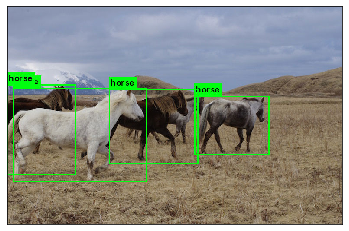

In [13]:
plot_image(img)

**Step 10:**  Just checking the inference of the yolov3 tiny network, remember that this will be less accurrate but more compact than the full yolo.  

We must train the network to improve tha acurracy.

You could check finally the file predictions. Probably yolo will misclassify the horses to other animals and also do not localize well the objects (horses).

In [14]:
!./darknet detect cfg/yolov3-tiny.cfg weights/yolov3-tiny.weights data/horses.jpg

layer     filters    size              input                output
    0 conv     16  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  16  0.150 BFLOPs
    1 max          2 x 2 / 2   416 x 416 x  16   ->   208 x 208 x  16
    2 conv     32  3 x 3 / 1   208 x 208 x  16   ->   208 x 208 x  32  0.399 BFLOPs
    3 max          2 x 2 / 2   208 x 208 x  32   ->   104 x 104 x  32
    4 conv     64  3 x 3 / 1   104 x 104 x  32   ->   104 x 104 x  64  0.399 BFLOPs
    5 max          2 x 2 / 2   104 x 104 x  64   ->    52 x  52 x  64
    6 conv    128  3 x 3 / 1    52 x  52 x  64   ->    52 x  52 x 128  0.399 BFLOPs
    7 max          2 x 2 / 2    52 x  52 x 128   ->    26 x  26 x 128
    8 conv    256  3 x 3 / 1    26 x  26 x 128   ->    26 x  26 x 256  0.399 BFLOPs
    9 max          2 x 2 / 2    26 x  26 x 256   ->    13 x  13 x 256
   10 conv    512  3 x 3 / 1    13 x  13 x 256   ->    13 x  13 x 512  0.399 BFLOPs
   11 max          2 x 2 / 1    13 x  13 x 512   ->    13 x  13 x 512
   12 con

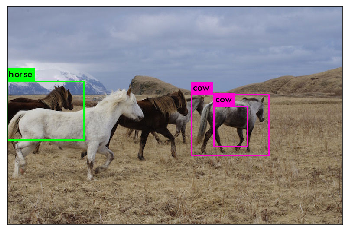

In [15]:
plot_image(img)

**Step 11:**  Before start training we need data.  First we must create the 'img' and 'lbl' folders.  The folder names could be anyone, but in my case I hard coded it.

In [16]:
os.chdir(darknetdir)
fdir = darknetdir + imgdir
create_dir(fdir)
fdir = darknetdir + lbldir
create_dir(fdir)

[INFO] - Directory /content/darknet/img/ already exists.
[INFO] - Directory /content/darknet/lbl/ already exists.


**Step 12:**Download OpenImages Dataset.  You could start from any annotation up to a final annotation or download the full dataset.  I made this in that way because we are using Colab and will be a limited time of use of the GPU, aproximately 12 hrs.

In [17]:
# Download Dataset.
# No matter what, the folder will be cleaned initially
# numberOfAnnotations
#     -1.  Starts from 0 to all annotations, override
#      0.  Do not download
#    > 0.  Starts downloading from 'start' to 'start + numberOfAnnotations'

fdir = darknetdir
os.chdir(fdir)
download_openimages(classes, start=0, numberOfAnnotations=200)

[INFO] - Removing (if exists) and Creating directory 'img' in /content/darknet
[INFO] - Removing (if exists) and Creating directory 'lbl' in /content/darknet
[INFO] - Class 1/1 : Person
[INFO] - Total number of annotations to download: 200
[INFO] - Starting from annotation 0.
[INFO] - Annotation count : 0. 1 of 200 = 0.5000%
[INFO] - Annotation count : 1. 2 of 200 = 1.0000%
[INFO] - Annotation count : 2. 3 of 200 = 1.5000%
[INFO] - Annotation count : 3. 4 of 200 = 2.0000%
[INFO] - Annotation count : 4. 5 of 200 = 2.5000%
[INFO] - Annotation count : 5. 6 of 200 = 3.0000%
[INFO] - Annotation count : 6. 7 of 200 = 3.5000%
[INFO] - Annotation count : 7. 8 of 200 = 4.0000%
[INFO] - Annotation count : 8. 9 of 200 = 4.5000%
[INFO] - Annotation count : 9. 10 of 200 = 5.0000%
[INFO] - Annotation count : 10. 11 of 200 = 5.5000%
[INFO] - Annotation count : 11. 12 of 200 = 6.0000%
[INFO] - Annotation count : 12. 13 of 200 = 6.5000%
[INFO] - Annotation count : 13. 14 of 200 = 7.0000%
[INFO] - Annot

**Step 13:**Now we create the .data file that contains the paths to the training, test sets; classes and where will be the trained weights of yolo, in this case, TinyYOLOv3

In [18]:
# This will create the .data file in cfg folder
# automatically based on the previous information
# _yolov3-tiny.data will be on folder /content/darknet/cfg

os.chdir(darknetdir)
create_data_file(dirs=[cfgdir, datadir, bckdir], nclasses=len(classes), fname=fname)

[INFO] - Created ./cfg/_yolov3-tiny.data successfully.
[INFO] - classes = 1
[INFO] - train  path = ./_yolov3-tiny_train.txt
[INFO] - valid  path = ./_yolov3-tiny_test.txt
[INFO] - names  path = ./data/_yolov3-tiny.names
[INFO] - backup path = ./backup
[INFO] - Please verify those are the correct paths, we use /content/darket/ as current directory


**Step 14:**Now we create the configuration file .cfg that contains all the hyperparameter for the training.  Basically you need to modify only the batch, subdivisions, classses and filters, but if you want fine tunning you could go ahead and tune these others parameters too

In [19]:
# This will create the .cfg file containing all the
# information of the filters and hyperparameters
# _yolov3-tiny.cfg will be on folder /content/darknet/cfg

os.chdir(darknetdir)
create_cfg_file(cfgdir=cfgdir, hyperp=hyperparams, nclasses=len(classes), max_batches=max_batches)

[INFO] - Replacing line 2 in _yolov3-tiny.cfg as batch=16
[INFO] - Replacing line 3 in _yolov3-tiny.cfg as subdivisions=4
[INFO] - Replacing line 7 in _yolov3-tiny.cfg as width=416
[INFO] - Replacing line 8 in _yolov3-tiny.cfg as height=416
[INFO] - Replacing line 9 in _yolov3-tiny.cfg as channels=3
[INFO] - Replacing line 10 in _yolov3-tiny.cfg as momentum=0.9
[INFO] - Replacing line 11 in _yolov3-tiny.cfg as decay=0.0005
[INFO] - Replacing line 12 in _yolov3-tiny.cfg as angle=0
[INFO] - Replacing line 13 in _yolov3-tiny.cfg as saturation=1.5
[INFO] - Replacing line 14 in _yolov3-tiny.cfg as exposure=1.5
[INFO] - Replacing line 15 in _yolov3-tiny.cfg as hue=0.1
[INFO] - Replacing line 17 in _yolov3-tiny.cfg as learning_rate=0.001
[INFO] - Replacing line 18 in _yolov3-tiny.cfg as burn_in=400
[INFO] - Replacing line 19 in _yolov3-tiny.cfg as max_batches=5200
[INFO] - Replacing line 21 in _yolov3-tiny.cfg as steps=3800
[INFO] - Replacing line 22 in _yolov3-tiny.cfg as scales=0.1
[INFO] -

**Step 15:**Just creating the .names file, it will contain all the classes that we want to detect.

In [20]:
# _yolov3-tiny.names    on folder /content/darknet/data
os.chdir(darknetdir)
create_names_file(namesdir=namesdir, classes=classes)

[INFO] - Created class Person
[INFO] - File _yolov3-tiny.names created successfully in /content/darknet/data/_yolov3-tiny.names


**Step 16:**Now we extract the partial weights of the yolo network before to start the training.

In [21]:
!./darknet partial cfg/yolov3-tiny.cfg weights/yolov3-tiny.weights weights/yolov3-tiny.conv.22 22

layer     filters    size              input                output
    0 conv     16  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  16  0.150 BFLOPs
    1 max          2 x 2 / 2   416 x 416 x  16   ->   208 x 208 x  16
    2 conv     32  3 x 3 / 1   208 x 208 x  16   ->   208 x 208 x  32  0.399 BFLOPs
    3 max          2 x 2 / 2   208 x 208 x  32   ->   104 x 104 x  32
    4 conv     64  3 x 3 / 1   104 x 104 x  32   ->   104 x 104 x  64  0.399 BFLOPs
    5 max          2 x 2 / 2   104 x 104 x  64   ->    52 x  52 x  64
    6 conv    128  3 x 3 / 1    52 x  52 x  64   ->    52 x  52 x 128  0.399 BFLOPs
    7 max          2 x 2 / 2    52 x  52 x 128   ->    26 x  26 x 128
    8 conv    256  3 x 3 / 1    26 x  26 x 128   ->    26 x  26 x 256  0.399 BFLOPs
    9 max          2 x 2 / 2    26 x  26 x 256   ->    13 x  13 x 256
   10 conv    512  3 x 3 / 1    13 x  13 x 256   ->    13 x  13 x 512  0.399 BFLOPs
   11 max          2 x 2 / 1    13 x  13 x 512   ->    13 x  13 x 512
   12 con

**Step 17:**Split the dataset to as you wish, i always like 80/20 training/test sets.

In [22]:
os.chdir(darknetdir)
split_data_set(imgdir, test_set_percentage=0.2)


[INFO] - Generated 10 images on the test set.
[INFO] - Generated 53 images on the training set.


**Step 18:**Something important is that you have to move all the labels to the image folder, that is what i am doing in this step.

In [0]:
!find ./lbl -name '*.txt' -exec mv --target-directory='./img/' '{}' +

**Step 19:**Now is time to train our custom detector.  The weights will be saved on the /content/darknet/backup/ folder.  

When is good to train your detector?, well, you could use the link of http://www.learnopencv.com about training your custom yolov3 detector in the references and download the plotLoss.py file, after that download from this darknet folder the train.log and call in your computer >>python plotLoss.py train.log, it will save an image seeing the training loss.

In [0]:
# Start the training
# _yolov3-tiny.backup will be on folder /content/darknet/backup
os.chdir(darknetdir)
!./darknet detector train cfg/_yolov3-tiny.data cfg/_yolov3-tiny.cfg weights/yolov3-tiny.conv.22 > train.log &

**Step 20:**Its time to train test the detector.  Upload an image of your something similar that you trained.  Search for google images of that.

Also you could use this to upload files or your own dataset.

In [32]:
# Use this to upload a file or group of files to a folder if you want.
# I.e., you could upload your configuration files, weights, image or labels...
# ... to their corresponding folder
os.chdir(darknetdir)
folder='./'
import_file_to_folder(folder)

Saving person.jpg to person.jpg
[INFO] - User uploaded file "person.jpg" with length 40513 bytes


**Step 21:**Test the trained model.  First we are copying the trained weights to the folder /content/darknet/weights and later we will make inference of the image.

In [33]:
# Test the trained model
os.chdir(darknetdir)
!mv ./backup/_yolov3-tiny.backup ./weights/_yolov3-tiny.backup
!./darknet detect cfg/_yolov3-tiny.cfg weights/_yolov3-tiny.backup person.jpg

mv: cannot stat './backup/_yolov3-tiny.backup': No such file or directory
layer     filters    size              input                output
    0 conv     16  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  16  0.150 BFLOPs
    1 max          2 x 2 / 2   416 x 416 x  16   ->   208 x 208 x  16
    2 conv     32  3 x 3 / 1   208 x 208 x  16   ->   208 x 208 x  32  0.399 BFLOPs
    3 max          2 x 2 / 2   208 x 208 x  32   ->   104 x 104 x  32
    4 conv     64  3 x 3 / 1   104 x 104 x  32   ->   104 x 104 x  64  0.399 BFLOPs
    5 max          2 x 2 / 2   104 x 104 x  64   ->    52 x  52 x  64
    6 conv    128  3 x 3 / 1    52 x  52 x  64   ->    52 x  52 x 128  0.399 BFLOPs
    7 max          2 x 2 / 2    52 x  52 x 128   ->    26 x  26 x 128
    8 conv    256  3 x 3 / 1    26 x  26 x 128   ->    26 x  26 x 256  0.399 BFLOPs
    9 max          2 x 2 / 2    26 x  26 x 256   ->    13 x  13 x 256
   10 conv    512  3 x 3 / 1    13 x  13 x 256   ->    13 x  13 x 512  0.399 BFLOPs
   11

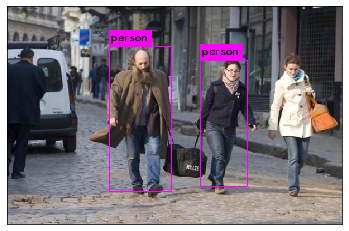

In [34]:
testimg = '/content/darknet/predictions.jpg'
plot_image(testimg)

**Step 22:**Search and kill the darknet executable if it is still training

In [13]:
# Search for a process
# Kills a process

!ps -fC darknet
!pkill darknet

UID          PID    PPID  C STIME TTY          TIME CMD
root      115217       1 99 00:58 ?        00:26:23 ./darknet detector train cfg


#References
* [1] [YOLOv3: An Incremental Improvement](https://arxiv.org/abs/1804.02767v1)
* [2] [YOLOv3 - LearnOpenCV.com](https://www.learnopencv.com/deep-learning-based-object-detection-using-yolov3-with-opencv-python-c/)
* [3] [YOLOv3 - PyImagesearch.com](https://www.pyimagesearch.com/2018/11/12/yolo-object-detection-with-opencv/)
* [4] [YOLOv3 Training - LearnOpenCV.com](https://www.learnopencv.com/training-yolov3-deep-learning-based-custom-object-detector/)
* [5] [How to unmount a google colab file](https://askubuntu.com/questions/979552/unmount-google-drive-ocamlfuse)
* [6] [How to use urllib](https://docs.python.org/3.1/howto/urllib2.html)